In [27]:
# imports
import seaborn as sbn
import json, re, time, unicodedata, unidecode, codecs, random, math, warnings, itertools
from pprint import pprint
from lxml import etree
from pattern.nl import parse, split, parsetree
from collections import defaultdict, Counter
from datetime import date, datetime, timedelta
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import numpy as np
from nltk.tokenize import sent_tokenize, word_tokenize
from pattern.nl import sentiment
import pandas as pd
from scipy.stats.mstats import normaltest
from tqdm import tqdm_notebook as tqdm

In [16]:
# files
#MWE
#topics = json.load(open('D:\\4. Data\\Amazones_Forum_Export_JSON\\MWE_topic.json'))
#posts = json.load(open('D:\\4. Data\\Amazones_Forum_Export_JSON\\MWE.json'))
#regular
forums = json.load(open('D:\\4. Data\\Amazones_Forum_Export_JSON\\2017-12-07T13-35-45 _amazones_forums_export.json'))
# zorg voor een nieuwe versie van dit bestand; verkeerd opgeslagen dus je mist het kontje!
topics = json.load(open('D:\\4. Data\\Amazones_Forum_Export_JSON\\2017-12-07T13-36-51_amazones_forum_topics_export.json'))
posts = json.load(open('D:\\4. Data\\Amazones_Forum_Export_JSON\\2017-12-07T13-39-20_amazones_forum_posts_export.json'))
users = json.load(open('D:\\4. Data\\Amazones_Forum_Export_JSON\\2017-12-07T13-39-20_amazones_users_export.json'))

In [4]:
# remove non-ascii characters from file (otherwise they will become part of the tokens)
def remove_non_ascii(text):
    return unidecode.unidecode(text)
    #return ''.join([i if ord(i) < 128 else ' ' for i in text])

In [5]:
def cleanup(text):
    #remove all links, images, quotes, and emailaddresses
    text=re.sub('<a.*?>(.*?)</a>','',text) #remove links
    text=re.sub('(http:|www)\S*','',text) #remove links without markup
    text=re.sub('\[\\\/url\]','',text)
    text=re.sub('<img.*?/>', '',text) #remove images
    text=re.sub('<div class="bb-quote">((\s|\S)*?)</div>','',text) #remove quotes
    text=re.sub('<script.*?>([\S\s]*?)</script>','',text) #remove emailaddresses

    #replace all emoticon-icons
    text=re.sub('<img.*?title="(.*?)".*?/>', '(EMO:\\1)',text) #replace emoticons by textual indicators 

    # replace (most) sideways latin emoticons
    text=re.sub('[^>]:-?(\)|\])','(EMO:smiley)',text)
    text=re.sub(u'☺️','(EMO:smiley)',text)
    text=re.sub('[^>]:-?(\(|\[)','(EMO:sad)',text)
    text=re.sub(';-?(\)|\])','(EMO:wink)',text)
    text=re.sub(r'(:|;|x|X)-?(D)+\b','(EMO:laugh)',text)
    text=re.sub(':-?(/|\\\|\|)','(EMO:frown)',text)
    text=re.sub(r'(:|;)-?(p|P)+\b','(EMO:cheeky)',text)
    text=re.sub('(:|;)(\'|\")-?(\(|\[)','(EMO:cry)',text)
    text=re.sub('\<3+','(EMO:heart)',text)
    text=re.sub(u'❤️','(EMO:heart)',text)
    text=re.sub('((\>:-?(\(|\]))|(\>?:-?@))','(EMO:angry)',text)
    text=re.sub('\>:-?(\)|\])','(EMO:evil)',text)
    text=re.sub(r'(:|;)-?(O|o|0)+\b','(EMO:shock)',text)
    text=re.sub('(:|;)-?(K|k|x|X)','(EMO:kiss)',text)
    # :s
    # :x is eigenlijk geen kus, geloof ik...


    #other important adjustments:
    text=re.sub('m\'?n\s','mijn ',text) # replacing m'n and mn with mijn, so it gets parsed correctly.
    text=re.sub('z\'?n\s','zijn ',text) #replacing z'n and zn with zijn
    text=re.sub('d\'?r\s','haar ',text) #replacing d'r and dr with zijn (only if followed by space, so dr. stays dr.)

    # replace all emoticons (and other things) written between double colons
    text=re.sub(':([a-zA-Z]+):','(EMO:\\1)',text)

    # remove remaining markup
    text=re.sub('</?(ol|style|b|p|em|u|i|strong|br|span|div|blockquote|li)(.*?)/?>','',text)
    text=re.sub('(\[|\]|\{|\})', '',text)

    # separate text from punctuation (may cause double/triple spaces - does not matter at this point)
    text = re.sub('(\.{2,}|/|\)|,|!|\?)','\\1 ',text) # space behind
    text=re.sub('(/|\()',' \\1',text) # space in front
    text=re.sub('(\w{2,})(\.|,)','\\1 \\2 ',text) #space 'between'

    return(text)

In [19]:
# make two dictionaries: user's post T imes, and user's P ost texts.
def make_P_T_and_D(topics,posts,count=2500):
    P = defaultdict(list)
    T = defaultdict(list)
    D = []

    with tqdm(total=len(topics)) as pbar:
        for t in tqdm(reversed(topics)): 
            pbar.update(1)
            P[t['Author uid']].append((remove_non_ascii(cleanup(t["Body"])),1))
            T[t['Author uid']].append(t['Post date'])
            D.append(datetime.strptime(t['Post date'], '%d/%m/%Y - %H:%M'))
    
    with tqdm(total=len(posts)) as pbar:
        for p in tqdm(reversed(posts)):
            pbar.update(1)
            P[p['Auteur-uid']].append((remove_non_ascii(cleanup(p["Body"])),0))
            T[p['Auteur-uid']].append(p['Datum van inzending'])
            D.append(datetime.strptime(p['Datum van inzending'], '%d/%m/%Y - %H:%M'))

    return (P,T,D)

In [7]:
def make_binlist(D,timetick=1): #timetick in days
    lower = min(D)
    upper = max(D)

    if lower.time()>=datetime.strptime('4:00','%H:%M').time():
        lower = lower.replace(hour = 4, minute = 0)
    else:
        lower = (lower+timedelta(days=-1)).replace(hour=4,minute=0)

    if upper.time()<datetime.strptime('12:00','%H:%M').time():
        upper = upper.replace(hour = 4, minute = 0)
    else:
        upper = (upper+timedelta(days=1)).replace(hour=4,minute=0)

    return([lower + timedelta(days=x) for x in range(0, (upper-lower).days, timetick)])

In [8]:
def determine_questionmarks(body):
    Q = 0
    for sentence in sent_tokenize(body):
        if re.search('\?+', sentence):
            Q+=1
    if len(sent_tokenize(body))!=0:
        return float(Q)/float(len(sent_tokenize(body)))
    else:
        return 0

# expects a string
# returns an int, representing the average sentiment score per sentence in the string, calculated by pattern
def determine_sentiment(body):
    S = []
    for sentence in sent_tokenize(body):
        S.append(sentiment(sentence)[0])
    return np.mean(S)

# expects a string
# returns an int, representing the average objectivity score per sentence in the string, calculated by pattern
def determine_objectivity(body):
    O = []
    for sentence in sent_tokenize(body):
        O.append(sentiment(sentence)[1])
    return np.mean(O)

# expects a string
# returns an int, representing the total nr of sentences the string is built of
def determine_length(body):
    # in sentences:
    return(len(sent_tokenize(body)))

# expects a string
# returns an int, representing the average nr of words in sentences that occur in the string
def determine_sent_length(body):
    # in words:
    L = []
    for sentence in sent_tokenize(body):
        L.append(len(word_tokenize(sentence)))
    return np.mean(L)

In [9]:
def compare_variables(pp,user,nr_of_posts,mean_quest,mean_object,mean_sents,mean_length,mean_sents_length,nr_of_starts,nr_of_responses):
    fig = plt.figure(1)
    ax = plt.subplot(111)

    posts, = ax.plot(nr_of_posts.values(),'b.', label = 'nr of posts', alpha = 1) #blue
    senlength, = ax.plot(mean_sents_length.values(),'k.', label = 'mean sentence length (words)',alpha = 0) #yellow
    postlength, = ax.plot(mean_length.values(),'c.', label = 'mean post length (sentences)',alpha = 0) #cyan
    starts, = ax.plot(nr_of_starts.values(),'g.', label = 'start posts', alpha = 0) #black
    #responses, = ax.plot(nr_of_responses.values(),'y.', label = 'response posts', alpha = 0.5)
    
    first_legend = plt.legend(handles=[posts,senlength,postlength,starts], title = "left axis", loc='upper left', bbox_to_anchor=(0, -0.1),ncol=1)
    axx = plt.gca().add_artist(first_legend)
    
    ax1 = ax.twinx()
    qmarks, = ax1.plot(mean_quest.values(),'y.', label = 'question ratio',alpha = 0) #green
    ovalues, = ax1.plot(mean_object.values(),'r.', label = 'subjectivity',alpha = 0) #red
    svalues, = ax1.plot(mean_sent.values(),'m.', label = 'sentiment',alpha = 0) #magenta
    
    
    second_legend = plt.legend(handles=[qmarks,ovalues,svalues], title = "right axis",loc='upper right', bbox_to_anchor=(1, -0.1),ncol=1)

    ax.set_ylim(0,10)
    ax1.set_ylim(-1,1)
    
    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height, box.width, box.height * 0.7])
    box = ax1.get_position()
    ax1.set_position([box.x0, box.y0 + box.height, box.width, box.height * 0.7])
    
    plt.title(user)
    plt.show()
    pp.savefig(fig, dpi = 300, transparent = True)

In [10]:
def compare_two(user,x,y):
    x = x.values()
    y = y.values()
    
    plt.plot(x,y, 'bo', alpha = 0.1)
    plt.xlabel('questions per post')
    plt.ylabel('nr of responses')
    plt.xlim(0,10)
    plt.ylim(0,10)
    plt.title("correlation plot")
    #plt.show() # will show for all users separately if enabled

In [11]:
# determine which variables are non-normal, and make a mask for correlations that are measured nonparametrically
def mask_nonnormal(df,mask):
    for column in df:
        index = df.columns.get_loc(column)
        z,p = normaltest(df[column].tolist())
        # als de data in de kolom significant niet-normaal verdeeld is, activeer dan het maskeer voor de relevante rij en kolom
        if p<0.05:
            mask[index]=True #rijen blokkeren
            mask[0::1,index]=True #kolommen blokkeren
    return mask

In [12]:
def visualise(df, method):
    global averagedict, normaldict, nonnormaldict, countnonnormal
    rho = df.corr(method = m)
    mask = np.zeros_like(rho, dtype=np.bool)
    
    if method == 'pearson' or method == 'spearman':
        mask = mask_nonnormal(df,mask)
        cmap = sbn.diverging_palette(120, 260, n=21, s=80)
        cbar_kws= dict(use_gridspec=False,location="left",label= "Pearson's Rho")
    else:
        mask = ~mask_nonnormal(df,mask)
        cmap = sbn.diverging_palette(10, 30, n=21, s=99, l=65)
        cbar_kws = dict(use_gridspec=False,location="right",label= "Kendall's Tau")

    #mask the upper half of the figure
    mask[np.triu_indices_from(mask)] = True
    
    # calculate averages        
    for i,row in enumerate(mask):
        for j,column in enumerate(row):
            if column == False: # all unmasked positions
                averagedict[i,j].append(rho.iloc[i][j])
                if method == 'pearson' or method == 'spearman':
                    normaldict[i,j].append(rho.iloc[i][j])
                else:
                    nonnormaldict[i,j].append(rho.iloc[i][j])
                    countnonnormal[i,j].append(1)
    
    # make heatmap
    ax = sbn.heatmap(rho, mask=mask, cbar_kws = cbar_kws, cmap=cmap, vmin = -1, vmax = 1, annot = True, fmt='1.2f')
    plt.title('results of (non-)parametric correlation tests')
    plt.show()

In [13]:
def show_correlations(dictionaries,countnonnormal,rho):
    for d in dictionaries:
        frame = pd.DataFrame().reindex_like(rho)
        for (i,j) in d:
            frame.iloc[i][j]=np.nanmean(d[(i,j)])
        print frame

    frame = pd.DataFrame().reindex_like(rho)
    for (i,j) in countnonnormal:
        frame.iloc[i][j]=np.nansum(countnonnormal[(i,j)])
    print frame

In [14]:
def determine_week_activity(first_date,last_date,bindict):
    for d in range(0, (last_date-first_date).days,7):
        week_start = first_date+timedelta(days=d)
        week_end = first_date+timedelta(days=d+7)
        for date in list(itertools.chain.from_iterable(bindict.values())):
            if week_start<=datetime.strptime(date, '%d/%m/%Y - %H:%M')<week_end:
                weekcountdict[week_start,week_end].append(1)
        if len(weekcountdict[week_start,week_end])==0:
            weekcountdict[week_start,week_end] = []
    return weekcountdict

In [23]:
PTD = make_P_T_and_D(topics,posts) 
P = PTD[0]
T = PTD[1]
D = PTD[2]

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

In [25]:
for ID in [1845,917,902,2877,5572,4487,3124,905,1683,1143,2126,966,968,940,933,3808,1552,2389,2413,3211,1870,2287]:
    print ID, str(ID) in T.keys()

1845 True
917 True
902 True
2877 True
5572 True
4487 True
3124 True
905 True
1683 True
1143 True
2126 True
966 True
968 True
940 True
933 True
3808 True
1552 True
2389 True
2413 True
3211 True
1870 True
2287 True


A Jupyter Widget

User: 2317
posted one or more posts in 39 'bins'.
The first post:  2009-01-18 22:48:00
The last post:  2014-05-08 19:23:00
Activity spread over:  1935 days, 20:35:00
The average nr of posts per week:  0.1407942238267148 including long times of inactivity.
The average nr of posts in non-empty weeks:  1.3928571428571428
The range of activity:  0  to  3  posts per week

User: 2314
posted one or more posts in 152 'bins'.
The first post:  2008-11-26 09:29:00
The last post:  2012-01-02 14:25:00
Activity spread over:  1132 days, 4:56:00
The average nr of posts per week:  0.9382716049382716 including long times of inactivity.
The average nr of posts in non-empty weeks:  3.707317073170732
The range of activity:  0  to  43  posts per week

User: 2310
posted one or more posts in 55 'bins'.
The first post:  2008-12-11 13:37:00
The last post:  2009-11-17 22:40:00
Activity spread over:  341 days, 9:03:00
The average nr of posts per week:  1.1224489795918366 including long times of inactivity.
The av

The average nr of posts per week:  0.5 including long times of inactivity.
The average nr of posts in non-empty weeks:  2.0
The range of activity:  0  to  7  posts per week

User: 1144
posted one or more posts in 30 'bins'.
The first post:  2005-06-21 11:44:00
The last post:  2009-11-30 22:24:00
Activity spread over:  1623 days, 10:40:00
The average nr of posts per week:  0.12931034482758622 including long times of inactivity.
The average nr of posts in non-empty weeks:  1.3636363636363635
The range of activity:  0  to  3  posts per week

User: 2966
posted one or more posts in 549 'bins'.
The first post:  2010-11-18 09:49:00
The last post:  2017-02-10 22:43:00
Activity spread over:  2276 days, 12:54:00
The average nr of posts per week:  1.6840490797546013 including long times of inactivity.
The average nr of posts in non-empty weeks:  7.038461538461538
The range of activity:  0  to  50  posts per week

User: 549
posted one or more posts in 92 'bins'.
The first post:  2012-06-15 16:53:0

posted one or more posts in 91 'bins'.
The first post:  2015-01-05 17:24:00
The last post:  2017-12-03 17:23:00
Activity spread over:  1062 days, 23:59:00
The average nr of posts per week:  0.5986842105263158 including long times of inactivity.
The average nr of posts in non-empty weeks:  2.0681818181818183
The range of activity:  0  to  8  posts per week

User: 3783
posted one or more posts in 44 'bins'.
The first post:  2012-03-22 10:20:00
The last post:  2012-11-26 13:44:00
Activity spread over:  249 days, 3:24:00
The average nr of posts per week:  1.2222222222222223 including long times of inactivity.
The average nr of posts in non-empty weeks:  3.3846153846153846
The range of activity:  0  to  8  posts per week

User: 1801
posted one or more posts in 434 'bins'.
The first post:  2007-03-04 19:35:00
The last post:  2008-11-25 13:53:00
Activity spread over:  631 days, 18:18:00
The average nr of posts per week:  4.769230769230769 including long times of inactivity.
The average nr of 

The average nr of posts per week:  0.13636363636363635 including long times of inactivity.
The average nr of posts in non-empty weeks:  1.8
The range of activity:  0  to  4  posts per week

User: 928
posted one or more posts in 192 'bins'.
The first post:  2004-09-21 09:24:00
The last post:  2012-01-22 17:07:00
Activity spread over:  2679 days, 7:43:00
The average nr of posts per week:  0.5013054830287206 including long times of inactivity.
The average nr of posts in non-empty weeks:  3.3684210526315788
The range of activity:  0  to  14  posts per week

User: 5256
posted one or more posts in 38 'bins'.
The first post:  2014-12-29 18:12:00
The last post:  2016-07-13 16:51:00
Activity spread over:  561 days, 22:39:00
The average nr of posts per week:  0.4691358024691358 including long times of inactivity.
The average nr of posts in non-empty weeks:  1.8095238095238095
The range of activity:  0  to  4  posts per week

User: 1132
posted one or more posts in 44 'bins'.
The first post:  2005

The last post:  2006-04-21 16:41:00
Activity spread over:  443 days, 23:19:00
The average nr of posts per week:  2.078125 including long times of inactivity.
The average nr of posts in non-empty weeks:  3.1666666666666665
The range of activity:  0  to  8  posts per week

User: 1211
posted one or more posts in 31 'bins'.
The first post:  2005-10-14 12:19:00
The last post:  2006-03-15 09:37:00
Activity spread over:  151 days, 21:18:00
The average nr of posts per week:  1.4090909090909092 including long times of inactivity.
The average nr of posts in non-empty weeks:  2.066666666666667
The range of activity:  0  to  5  posts per week

User: 1215
posted one or more posts in 51 'bins'.
The first post:  2005-09-25 18:30:00
The last post:  2008-02-14 13:12:00
Activity spread over:  871 days, 18:42:00
The average nr of posts per week:  0.408 including long times of inactivity.
The average nr of posts in non-empty weeks:  2.6842105263157894
The range of activity:  0  to  9  posts per week

User

posted one or more posts in 101 'bins'.
The first post:  2012-05-15 17:24:00
The last post:  2015-05-15 12:01:00
Activity spread over:  1094 days, 18:37:00
The average nr of posts per week:  0.643312101910828 including long times of inactivity.
The average nr of posts in non-empty weeks:  4.391304347826087
The range of activity:  0  to  13  posts per week

User: 6095
posted one or more posts in 278 'bins'.
The first post:  2017-05-11 19:11:00
The last post:  2017-12-04 17:09:00
Activity spread over:  206 days, 21:58:00
The average nr of posts per week:  9.266666666666667 including long times of inactivity.
The average nr of posts in non-empty weeks:  9.586206896551724
The range of activity:  0  to  22  posts per week

User: 2541
posted one or more posts in 206 'bins'.
The first post:  2009-08-20 21:28:00
The last post:  2011-11-14 19:32:00
Activity spread over:  815 days, 22:04:00
The average nr of posts per week:  1.7606837606837606 including long times of inactivity.
The average nr o

The average nr of posts in non-empty weeks:  2.357142857142857
The range of activity:  0  to  10  posts per week

User: 3597
posted one or more posts in 55 'bins'.
The first post:  2012-01-14 15:22:00
The last post:  2012-08-11 19:12:00
Activity spread over:  210 days, 3:50:00
The average nr of posts per week:  1.8 including long times of inactivity.
The average nr of posts in non-empty weeks:  3.0
The range of activity:  0  to  10  posts per week

User: 1870
posted one or more posts in 114 'bins'.
The first post:  2007-05-29 23:34:00
The last post:  2011-12-21 17:35:00
Activity spread over:  1666 days, 18:01:00
The average nr of posts per week:  0.47478991596638653 including long times of inactivity.
The average nr of posts in non-empty weeks:  2.26
The range of activity:  0  to  7  posts per week

User: 977
posted one or more posts in 70 'bins'.
The first post:  2004-11-14 17:17:00
The last post:  2007-08-02 12:24:00
Activity spread over:  990 days, 19:07:00
The average nr of posts p

The average nr of posts per week:  2.1363636363636362 including long times of inactivity.
The average nr of posts in non-empty weeks:  2.764705882352941
The range of activity:  0  to  7  posts per week

User: 1783
posted one or more posts in 4045 'bins'.
The first post:  2007-02-14 18:37:00
The last post:  2017-12-01 22:29:00
Activity spread over:  3943 days, 3:52:00
The average nr of posts per week:  7.171985815602837 including long times of inactivity.
The average nr of posts in non-empty weeks:  7.617702448210923
The range of activity:  0  to  28  posts per week

User: 1071
posted one or more posts in 620 'bins'.
The first post:  2005-03-15 22:22:00
The last post:  2010-10-29 23:14:00
Activity spread over:  2054 days, 0:52:00
The average nr of posts per week:  2.108843537414966 including long times of inactivity.
The average nr of posts in non-empty weeks:  3.803680981595092
The range of activity:  0  to  15  posts per week

User: 1094
posted one or more posts in 33 'bins'.
The firs

The first post:  2013-01-12 12:58:00
The last post:  2017-11-24 01:30:00
Activity spread over:  1776 days, 12:32:00
The average nr of posts per week:  2.877952755905512 including long times of inactivity.
The average nr of posts in non-empty weeks:  3.7487179487179487
The range of activity:  0  to  19  posts per week

User: 3638
posted one or more posts in 31 'bins'.
The first post:  2012-01-04 21:21:00
The last post:  2012-02-25 12:36:00
Activity spread over:  51 days, 15:15:00
The average nr of posts per week:  3.875 including long times of inactivity.
The average nr of posts in non-empty weeks:  6.2
The range of activity:  0  to  22  posts per week

User: 2345
posted one or more posts in 180 'bins'.
The first post:  2009-01-10 16:34:00
The last post:  2010-06-16 21:22:00
Activity spread over:  522 days, 4:48:00
The average nr of posts per week:  2.4 including long times of inactivity.
The average nr of posts in non-empty weeks:  5.0
The range of activity:  0  to  18  posts per week


posted one or more posts in 51 'bins'.
The first post:  2008-08-29 19:33:00
The last post:  2017-08-22 09:27:00
Activity spread over:  3279 days, 13:54:00
The average nr of posts per week:  0.10874200426439233 including long times of inactivity.
The average nr of posts in non-empty weeks:  2.3181818181818183
The range of activity:  0  to  7  posts per week

User: 2240
posted one or more posts in 116 'bins'.
The first post:  2008-09-19 15:21:00
The last post:  2012-03-27 20:56:00
Activity spread over:  1285 days, 5:35:00
The average nr of posts per week:  0.6304347826086957 including long times of inactivity.
The average nr of posts in non-empty weeks:  2.188679245283019
The range of activity:  0  to  7  posts per week

User: 992
posted one or more posts in 31 'bins'.
The first post:  2005-04-18 16:19:00
The last post:  2012-08-14 17:57:00
Activity spread over:  2675 days, 1:38:00
The average nr of posts per week:  0.08093994778067885 including long times of inactivity.
The average nr o

The average nr of posts in non-empty weeks:  1.8125
The range of activity:  0  to  5  posts per week

User: 2034
posted one or more posts in 63 'bins'.
The first post:  2007-11-28 19:52:00
The last post:  2012-04-24 12:21:00
Activity spread over:  1608 days, 16:29:00
The average nr of posts per week:  0.27391304347826084 including long times of inactivity.
The average nr of posts in non-empty weeks:  1.96875
The range of activity:  0  to  6  posts per week

User: 1568
posted one or more posts in 33 'bins'.
The first post:  2011-03-22 15:41:00
The last post:  2017-05-03 22:18:00
Activity spread over:  2234 days, 6:37:00
The average nr of posts per week:  0.103125 including long times of inactivity.
The average nr of posts in non-empty weeks:  1.736842105263158
The range of activity:  0  to  6  posts per week

User: 1293
posted one or more posts in 82 'bins'.
The first post:  2005-11-11 09:41:00
The last post:  2011-08-22 10:39:00
Activity spread over:  2110 days, 0:58:00
The average nr 

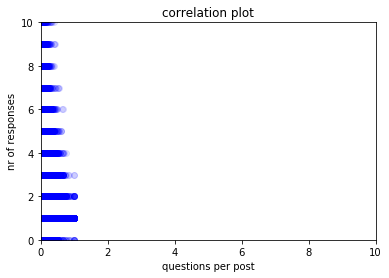

In [38]:
plt.close()
binlist = make_binlist(D,1) #timetick in (whole) days
pp = PdfPages("plots-author-BVN.pdf")
normaldict = defaultdict(list)
nonnormaldict = defaultdict(list)
averagedict = defaultdict(list)
countnonnormal = defaultdict(list)

for user in tqdm(T):
    if len(T[user])<30:
        pass # go to next user. This one has too little activity
    else:
        first_date = 0
        last_date = 0
        print "User:", user
        print "posted one or more posts in", len(T[user]), "'bins'."    
        
        # variables
        bindict = defaultdict(list)
        postdict = defaultdict(list)
        sendict = defaultdict(list)
        questdict = defaultdict(list)
        objecdict = defaultdict(list)
        lengthdict = defaultdict(list)
        senlengthdict = defaultdict(list)
        startsdict = defaultdict(list)
        responsesdict = defaultdict(list)
        
        weekcountdict = defaultdict(list)
        # length of posts (in words, or sentences)
        # nr of replies to posts vs nr of starting posts
        # linguistic markers, like adjectives / pronouns / emoticons, and the diversity of topics / vocabulary

        # variables (plottable)
        nr_of_posts = dict()
        mean_quest = dict()
        mean_sent = dict()
        mean_object = dict()
        mean_length = dict()
        mean_sents_length = dict()
        nr_of_starts = dict()
        nr_of_responses = dict()

        for index,boundary in enumerate(binlist):
            if index+1>=len(binlist):
                break
            else:
                lower = binlist[index]
                upper = binlist[index+1]

                for time in T[user]:
                    if lower<=datetime.strptime(time, '%d/%m/%Y - %H:%M')<upper:
                        if first_date == 0:
                            first_date = datetime.strptime(time, '%d/%m/%Y - %H:%M')
                            last_date = datetime.strptime(time, '%d/%m/%Y - %H:%M')
                        else:
                            last_date = datetime.strptime(time, '%d/%m/%Y - %H:%M')
                            
                        
                        body = P[user][T[user].index(time)][0]
                        meta = P[user][T[user].index(time)][1]

                        senti = determine_sentiment(body) # average sentiment per sentence in body
                        questionmarks = determine_questionmarks(body) # ratio of sentences in body ending with question marks
                        objectivity = determine_objectivity(body)
                        length = determine_length(body)
                        sentence_length = determine_sent_length(body)
                        if meta == 0: # 0 is for the response to a thread, 1 is the start of thread
                            response = 1
                            start = 0
                        elif meta == 1:
                            response = 0
                            start = 1

                        bindict[lower,upper].append(time)
                        postdict[lower,upper].append(body) 
                        sendict[lower,upper].append(senti)
                        questdict[lower,upper].append(questionmarks)
                        objecdict[lower,upper].append(objectivity)
                        lengthdict[lower,upper].append(length)
                        senlengthdict[lower,upper].append(sentence_length)
                        startsdict[lower,upper].append(start)
                        responsesdict[lower,upper].append(response)

            # fill up empty places in dictionary
            if len(bindict[lower,upper])==0:
                bindict[lower,upper]=[]
                postdict[lower,upper]=[]
                sendict[lower,upper]=[]
                questdict[lower,upper]=[]
                objecdict[lower,upper]=[]
                lengthdict[lower,upper]=[]
                senlengthdict[lower,upper]=[]
                startsdict[lower,upper]=[]
                responsesdict[lower,upper]=[]

        #convert dictionaries to things you want plotted, like averages:
        for lower,upper in bindict: 
            # mean nr of sentences per timetick
            if len(bindict[lower,upper])==0:
                nr_of_posts[lower,upper]=float('nan')
                mean_quest[lower,upper]=float('nan')
                mean_sent[lower,upper]=float('nan')
                mean_object[lower,upper]=float('nan')
                mean_length[lower,upper]=float('nan')
                mean_sents_length[lower,upper]=float('nan')
                nr_of_starts[lower,upper]=float('nan')
                nr_of_responses[lower,upper]=float('nan')
            else:
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore", category=RuntimeWarning)
                    nr_of_posts[lower,upper]=len(bindict[lower,upper])
                    mean_quest[lower,upper]=np.mean(questdict[lower,upper])
                    mean_sent[lower,upper]=np.mean(sendict[lower,upper])
                    mean_object[lower,upper]=np.mean(objecdict[lower,upper])
                    mean_length[lower,upper]=np.mean(lengthdict[lower,upper])
                    mean_sents_length[lower,upper]=np.mean(senlengthdict[lower,upper])
                    nr_of_starts[lower,upper]=np.nansum(startsdict[lower,upper])
                    nr_of_responses[lower,upper]=np.nansum(responsesdict[lower,upper])

        # we have collected all data for a single user, and now we do stuff with it:
        weekcount = determine_week_activity(first_date,last_date,bindict)   
        activity = [len(x) for x in weekcount.values()]
        activity_nonempty = [len(x) for x in weekcount.values() if not x==[]]
        
        print "The first post: ", first_date
        print "The last post: ", last_date
        print "Activity spread over: ", last_date-first_date
        print "The average nr of posts per week: ", np.mean(activity), "including long times of inactivity."
        print "The average nr of posts in non-empty weeks: ", np.mean(activity_nonempty)
        print "The range of activity: ", min([len(x) for x in weekcount.values()]), " to ", max([len(x) for x in weekcount.values()]), " posts per week"
        print
        # maak plotje van alle variabelen
        compare_variables(pp,user,nr_of_posts,mean_quest,mean_object,mean_sent,mean_length,mean_sents_length,nr_of_starts,nr_of_responses)
        #compare_two(user,mean_quest,nr_of_responses)
        
        # maak dataframe van alle variabelen
        df = pd.DataFrame({'Que': mean_quest.values(), 'Sub': mean_object.values(), 'Sen': mean_sent.values(),'Len': mean_length.values(), 'Wor': mean_sents_length.values(),'Sta': nr_of_starts.values(),'Res': nr_of_responses.values()}).dropna()

        #plot de boel:
        #plt.close()
        # bepaal correlatiematrix van variabelen
        for m in ['pearson', 'kendall']:
            rho = df.corr(method = m) #dubbel..
            #visualise(df, m)
        #plt.show()
plt.show()        
# show average correlations (per test, and in general)
#show_correlations([averagedict,normaldict,nonnormaldict],countnonnormal, rho)

pp.close()

In [103]:
#determine nr of posts in a week

first_date = datetime.strptime("25/10/2014 - 09:36", '%d/%m/%Y - %H:%M')
last_date = first_date + timedelta(days=366)
dates = [first_date + timedelta(days=62),first_date + timedelta(days=23),first_date + timedelta(days=14),first_date + timedelta(days=54)]

for d in range(0,(last_date-first_date).days,7):
    border1 = first_date+timedelta(days=d)
    border2 = first_date+timedelta(days=d+7)
    for a_date in dates:
        if border1<=a_date<border2:
            print border1, " \ ", a_date, " / ", border2
            # write to dictionary with borders as keys (start dict at first activity, end at last)

# determine average length of values in dictionary

2014-11-08 09:36:00  \  2014-11-08 09:36:00  /  2014-11-15 09:36:00
2014-11-15 09:36:00  \  2014-11-17 09:36:00  /  2014-11-22 09:36:00
2014-12-13 09:36:00  \  2014-12-18 09:36:00  /  2014-12-20 09:36:00
2014-12-20 09:36:00  \  2014-12-26 09:36:00  /  2014-12-27 09:36:00


In [120]:
frame = pd.DataFrame().reindex_like(rho)
for (i,j) in averagedict:
    print (i,j), np.nanmean(averagedict[(i,j)])
    frame.iloc[i][j]=np.nanmean(averagedict[(i,j)])
print frame

(6, 4) -0.0371477826962
(5, 4) -0.0116371475249
(5, 0) 0.167089688543
(3, 0) 0.0351211230674
(5, 2) 0.0491713185558
(6, 1) -0.0329269224226
(3, 1) 0.0569689490541
(3, 2) 0.167349250464
(2, 1) 0.247009057214
(6, 0) 0.110506895394
(6, 3) 0.0591017614612
(2, 0) 0.116947043632
(6, 2) 0.0647423888313
(4, 3) 0.0330315516744
(5, 1) 0.0062988958561
(4, 2) 0.0566331265763
(1, 0) 0.0776204892785
(5, 3) 0.18647860511
(4, 1) 0.151254831936
(6, 5) 0.290548054865
(4, 0) 0.0435062984641
          Len       Que       Res       Sen       Sta       Sub  Wor
Len       NaN       NaN       NaN       NaN       NaN       NaN  NaN
Que  0.077620       NaN       NaN       NaN       NaN       NaN  NaN
Res  0.116947  0.247009       NaN       NaN       NaN       NaN  NaN
Sen  0.035121  0.056969  0.167349       NaN       NaN       NaN  NaN
Sta  0.043506  0.151255  0.056633  0.033032       NaN       NaN  NaN
Sub  0.167090  0.006299  0.049171  0.186479 -0.011637       NaN  NaN
Wor  0.110507 -0.032927  0.064742  0.059